# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


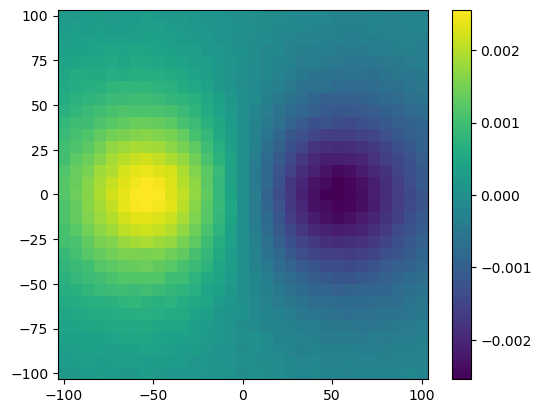

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f3a88e82710>,)

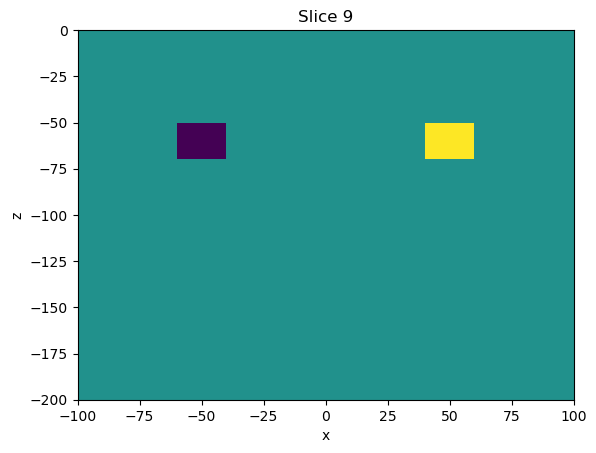

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

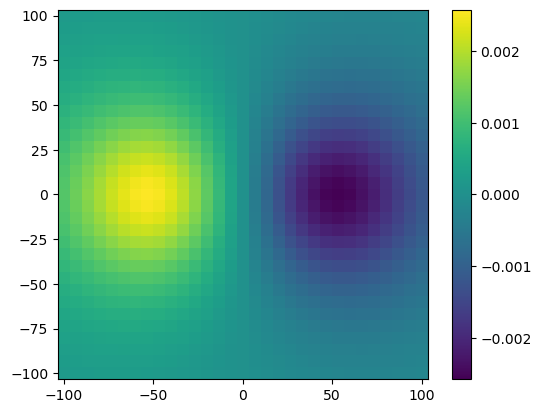

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
active_cells = np.ones(mesh.n_cells, dtype=bool)
depth_weights = depth_weighting(mesh, 0)
sparse_smallness = ii.SparseSmallness(
    mesh=mesh,
    active_cells=active_cells,
    norm=1,
    model_previous=None,
    cell_weights=depth_weights,
    irls=False,  # Start with IRLS deactivated
)

In [17]:
beta_0 = 1e5
regularization = beta_0 * sparse_smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00e+05 φs-1(m)

In [18]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Stopping criteria
chi_target = ii.ChiTarget(data_misfit, chi_target=1.0)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Preconditioner that updates on each iteration
preconditioner = ii.JacobiPreconditioner(phi)
minimizer_kwargs = dict(preconditioner=preconditioner)

# Inversion
l2_inversion = ii.Inversion(
    phi,
    initial_model,
    ii.conjugate_gradient,
    directives=[beta_cooler],
    stopping_criteria=chi_target,
    cache_models=True,
    minimizer_kwargs=minimizer_kwargs,
)

In [19]:
model_l2 = l2_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [20]:
l2_inversion.log.table

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Iteration ┃ β        ┃ φ_d      ┃ φ_m      ┃ β φ_m    ┃ φ        ┃ χ        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ 0         │ 1.00e+05 │ 1.67e+06 │ 0.00e+00 │ 0.00e+00 │ 1.67e+06 │ 1.74e+03 │
│ 1         │ 1.00e+05 │ 4.56e+03 │ 6.58e-01 │ 6.58e+04 │ 7.04e+04 │ 4.75e+00 │
│ 2         │ 5.00e+04 │ 1.78e+03 │ 6.95e-01 │ 3.48e+04 │ 3.65e+04 │ 1.85e+00 │
│ 3         │ 2.50e+04 │ 9.79e+02 │ 7.17e-01 │ 1.79e+04 │ 1.89e+04 │ 1.02e+00 │
│ 4         │ 1.25e+04 │ 7.42e+02 │ 7.30e-01 │ 9.12e+03 │ 9.86e+03 │ 7.72e-01 │
└───────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

In [21]:
l2_inversion.stopping_criteria.info(model_l2)

[x] ChiTarget
├── Condition: chi < chi_target
├── chi        = 7.72e-01
└── chi_target = 1.00e+00

(<matplotlib.collections.QuadMesh at 0x7f3a88dcda90>,)

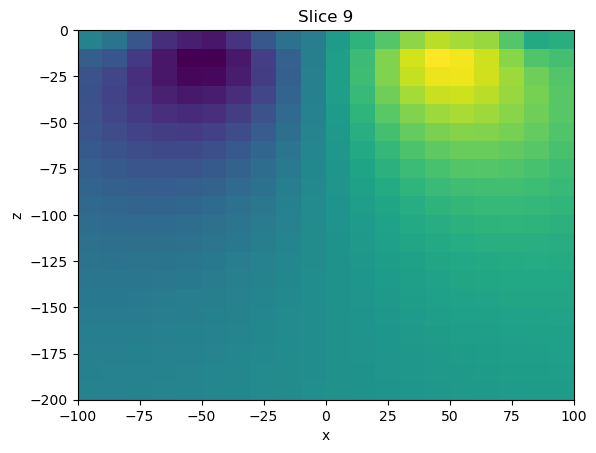

In [22]:
mesh.plot_slice(model_l2, normal="Y", slice_loc=0)

In [23]:
# Activate IRLS in smallness
# * Assign model to sparse smallness as previous model
# * Define epsilon: maximum abs value of the inverted model after the l2 inversion
sparse_smallness.activate_irls(model_l2)

# Define stopping criteria
smallness_not_changing = ii.ObjectiveChanged(sparse_smallness, rtol=1e-3)

# Define irls directive
irls_directive = ii.IRLS(
    sparse_smallness,
    data_misfit=data_misfit,
    regularization=regularization,
    model_stage_one=model_l2,
)

# Define sparse inversion
sparse_inversion = ii.Inversion(
    phi,
    model_l2,
    ii.conjugate_gradient,
    directives=[irls_directive],
    stopping_criteria=smallness_not_changing,
    cache_models=True,
    max_iterations=80,
    minimizer_kwargs=minimizer_kwargs,
)

# Add columns to log
sparse_inversion.log.add_column(
    "irls threshold", lambda _, __: sparse_smallness.threshold
)
sparse_inversion.log.add_column(
    "|phi_m - phi_m*| / |phi_m*|", lambda _, model: smallness_not_changing.ratio(model)
)

In [24]:
model = sparse_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [25]:
sparse_inversion.log.table

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃           ┃          ┃          ┃          ┃          ┃          ┃          ┃                ┃ |phi_m - phi_m*| ┃
┃ Iteration ┃ β        ┃ φ_d      ┃ φ_m      ┃ β φ_m    ┃ φ        ┃ χ        ┃ irls threshold ┃ / |phi_m*|       ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 0         │ 1.25e+04 │ 7.42e+02 │ 2.45e+02 │ 3.07e+06 │ 3.07e+06 │ 7.72e-01 │ 2.58e-03       │ nan              │
│ 1         │ 1.25e+04 │ 6.68e+05 │ 3.06e+01 │ 3.83e+05 │ 1.05e+06 │ 6.95e+02 │ 2.58e-03       │ 8.75e-01         │
│ 2         │ 4.69e+03 │ 2.70e+05 │ 8.28e+01 │ 3.89e+05 │ 6.58e+05 │ 2.80e+02 │ 2.58e-03       │ 1.70e+00         │
│ 3         │ 1.77e+03 │ 7.43e+04 │ 1.48e+02 │ 2.61e+05 │ 3.35e+05 │ 7.73e+01 │ 2.58e-03       │ 7.84e-01         │
│ 4         │ 6.71e+02 │ 1.61e+04 │ 1.97e+02 │ 1.33e+05 │ 1.49e+05 │ 1.67e+01 │ 2.58e-03       │ 3.36e-01         │
│ 5         │ 2.67e+02 │ 3.68e+03 │ 2.24e+02 │ 5.99e+04 │ 6.36e+04 │ 3.83e+00 │ 2.58e-03       │ 1.36e-01         │
│ 6         │ 1.27e+02 │ 1.46e+03 │ 2.36e+02 │ 3.00e+04 │ 3.14e+04 │ 1.52e+00 │ 2.58e-03       │ 5.07e-02         │
│ 7         │ 8.01e+01 │ 1.01e+03 │ 2.40e+02 │ 1.92e+04 │ 2.02e+04 │ 1.05e+00 │ 2.58e-03       │ 1.84e-02         │
│ 8         │ 5.94e+01 │ 8.64e+02 │ 2.42e+02 │ 1.44e+04 │ 1.53e+04 │ 8.99e-01 │ 2.58e-03       │ 8.67e-03         │
│ 9         │ 4.78e+01 │ 7.96e+02 │ 2.43e+02 │ 1.16e+04 │ 1.24e+04 │ 8.28e-01 │ 2.58e-03       │ 5.25e-03         │
│ 10        │ 4.78e+01 │ 8.43e+02 │ 2.83e+02 │ 1.35e+04 │ 1.44e+04 │ 8.77e-01 │ 2.06e-03       │ 1.64e-01         │
│ 11        │ 3.90e+01 │ 7.85e+02 │ 2.85e+02 │ 1.11e+04 │ 1.19e+04 │ 8.17e-01 │ 2.06e-03       │ 4.68e-03         │
│ 12        │ 3.90e+01 │ 8.23e+02 │ 3.25e+02 │ 1.27e+04 │ 1.35e+04 │ 8.57e-01 │ 1.65e-03       │ 1.42e-01         │
│ 13        │ 3.22e+01 │ 7.75e+02 │ 3.26e+02 │ 1.05e+04 │ 1.13e+04 │ 8.06e-01 │ 1.65e-03       │ 4.18e-03         │
│ 14        │ 3.22e+01 │ 8.05e+02 │ 3.65e+02 │ 1.17e+04 │ 1.25e+04 │ 8.38e-01 │ 1.32e-03       │ 1.18e-01         │
│ 15        │ 3.22e+01 │ 8.37e+02 │ 3.99e+02 │ 1.28e+04 │ 1.37e+04 │ 8.71e-01 │ 1.06e-03       │ 9.37e-02         │
│ 16        │ 2.63e+01 │ 7.86e+02 │ 4.01e+02 │ 1.05e+04 │ 1.13e+04 │ 8.18e-01 │ 1.06e-03       │ 4.43e-03         │
│ 17        │ 2.63e+01 │ 8.09e+02 │ 4.29e+02 │ 1.13e+04 │ 1.21e+04 │ 8.42e-01 │ 8.44e-04       │ 7.03e-02         │
│ 18        │ 2.63e+01 │ 8.32e+02 │ 4.51e+02 │ 1.19e+04 │ 1.27e+04 │ 8.66e-01 │ 6.76e-04       │ 5.21e-02         │
│ 19        │ 2.16e+01 │ 7.85e+02 │ 4.53e+02 │ 9.78e+03 │ 1.06e+04 │ 8.17e-01 │ 6.76e-04       │ 4.38e-03         │
│ 20        │ 2.16e+01 │ 8.01e+02 │ 4.69e+02 │ 1.01e+04 │ 1.09e+04 │ 8.34e-01 │ 5.40e-04       │ 3.58e-02         │
│ 21        │ 2.16e+01 │ 8.18e+02 │ 4.81e+02 │ 1.04e+04 │ 1.12e+04 │ 8.52e-01 │ 4.32e-04       │ 2.53e-02         │
│ 22        │ 1.79e+01 │ 7.78e+02 │ 4.83e+02 │ 8.64e+03 │ 9.41e+03 │ 8.10e-01 │ 4.32e-04       │ 4.27e-03         │
│ 23        │ 1.79e+01 │ 7.90e+02 │ 4.91e+02 │ 8.77e+03 │ 9.56e+03 │ 8.22e-01 │ 3.46e-04       │ 1.59e-02         │
│ 24        │ 1.79e+01 │ 8.05e+02 │ 4.96e+02 │ 8.87e+03 │ 9.67e+03 │ 8.37e-01 │ 2.77e-04       │ 1.08e-02         │
│ 25        │ 1.79e+01 │ 8.20e+02 │ 4.99e+02 │ 8.92e+03 │ 9.74e+03 │ 8.54e-01 │ 2.21e-04       │ 6.39e-03         │
│ 26        │ 1.48e+01 │ 7.82e+02 │ 5.02e+02 │ 7.41e+03 │ 8.20e+03 │ 8.14e-01 │ 2.21e-04       │ 4.68e-03         │
│ 27        │ 1.48e+01 │ 7.93e+02 │ 5.03e+02 │ 7.43e+03 │ 8.22e+03 │ 8.25e-01 │ 1.77e-04       │ 1.90e-03         │
│ 28        │ 1.48e+01 │ 8.07e+02 │ 5.03e+02 │ 7.43e+03 │ 8.24e+03 │ 8.39e-01 │ 1.42e-04       │ 7.37e-04         │
└───────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴────────────────┴──────────────────┘

In [26]:
sparse_inversion.stopping_criteria.info(sparse_inversion.model)

[x] ObjectiveChanged
├── Condition: |φ(m) - φ(m_prev)| <= max(|φ(m_prev)| * rtol, atol)
├── |φ(m) - φ(m_prev)| = 3.70e-01
├── |φ(m_prev)|        = 5.03e+02
├── rtol               = 1.00e-03
└── atol               = 0.00e+00

In [27]:
log = sparse_inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,irls threshold,|phi_m - phi_m*| / |phi_m*|
iter,,,,,,,,
0,12500.000000,741.566068,245.372402,3.067155e+06,3.067897e+06,0.771661,0.002577,NaN
1,12500.000000,667771.895676,30.611034,3.826379e+05,1.050410e+06,694.871900,0.002577,0.875247
2,4694.440675,269507.028621,82.795431,3.886782e+05,6.581853e+05,280.444359,0.002577,1.704758
3,1766.873782,74291.359130,147.735022,2.610291e+05,3.353205e+05,77.306305,0.002577,0.784338
4,671.396013,16066.920672,197.387594,1.325252e+05,1.485922e+05,16.718960,0.002577,0.336092
5,267.267591,3681.177096,224.272223,5.994070e+04,6.362187e+04,3.830569,0.002577,0.136202
6,127.145618,1456.108324,235.651453,2.996205e+04,3.141816e+04,1.515201,0.002577,0.050738
7,80.055933,1008.747691,239.985870,1.921229e+04,2.022104e+04,1.049685,0.002577,0.018393
8,59.446947,863.854493,242.067266,1.439016e+04,1.525401e+04,0.898912,0.002577,0.008673


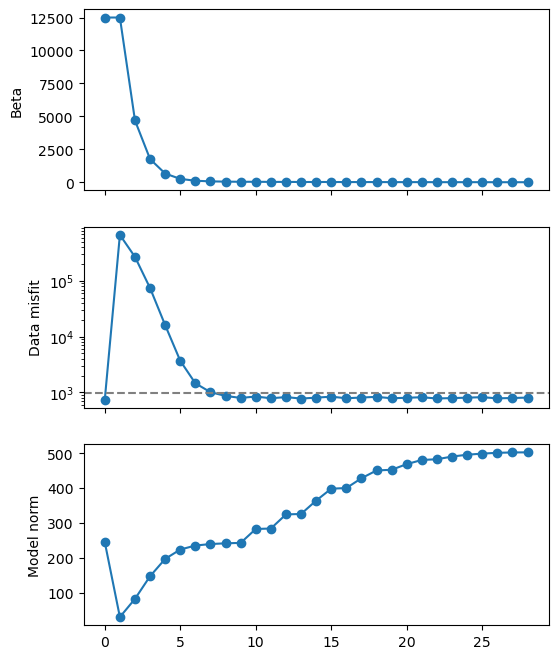

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

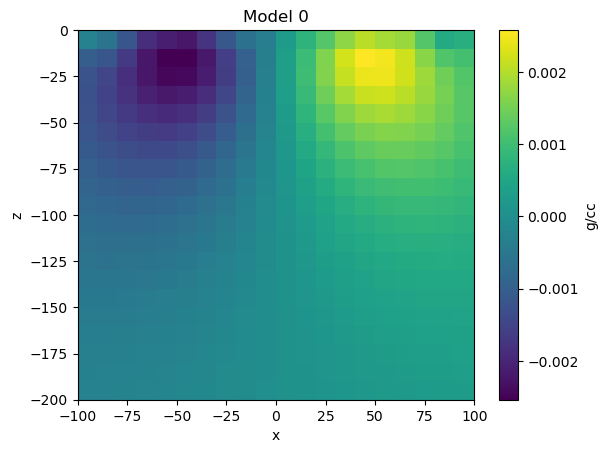

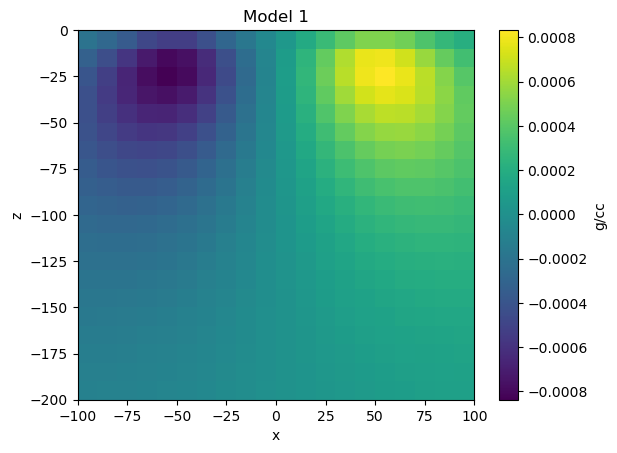

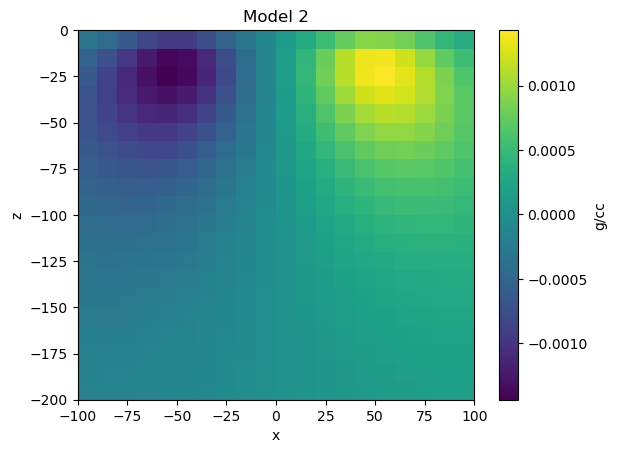

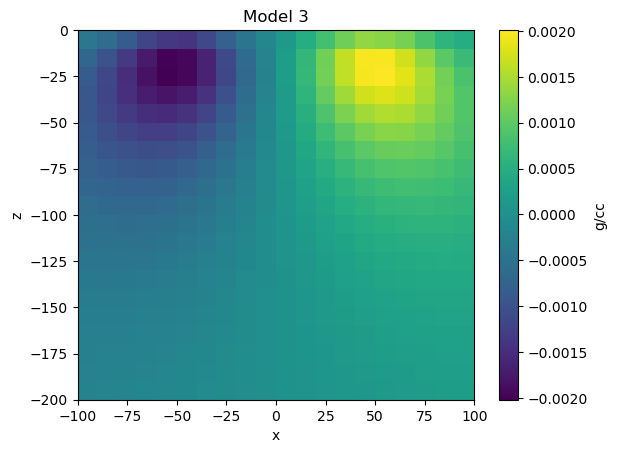

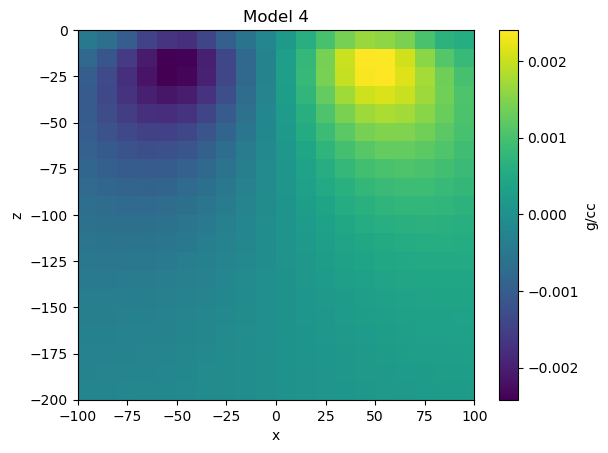

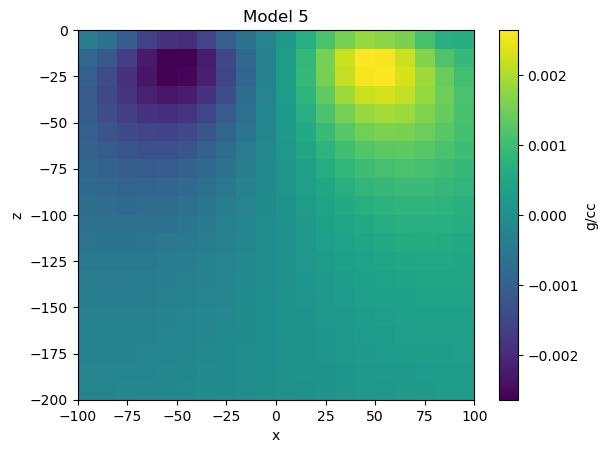

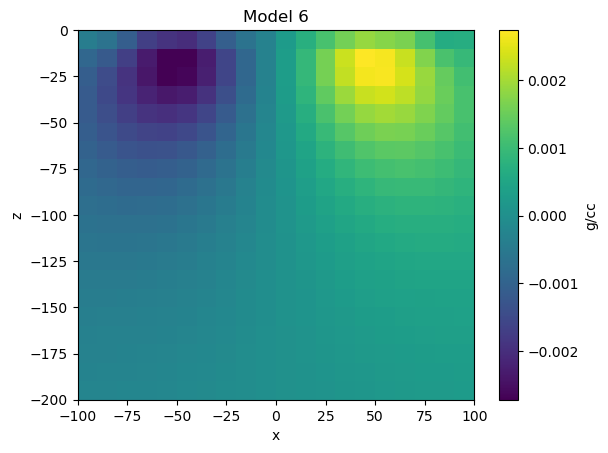

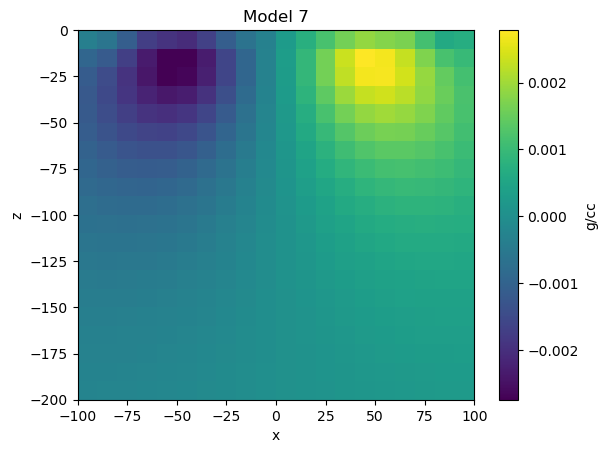

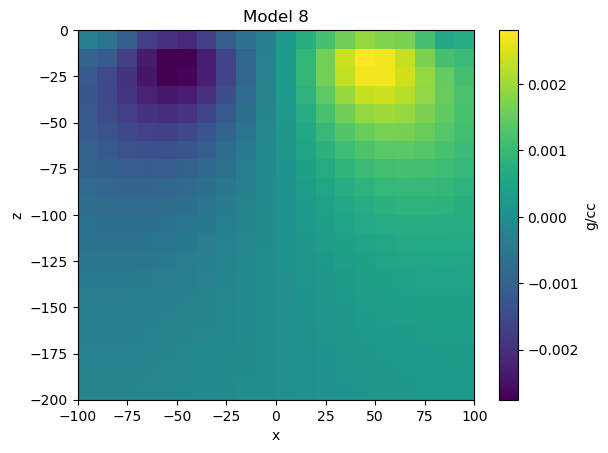

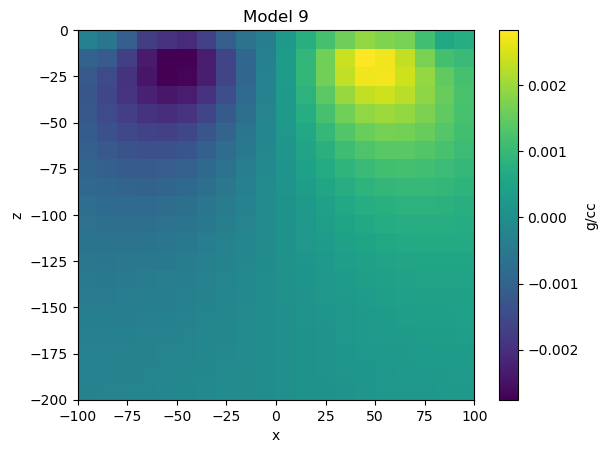

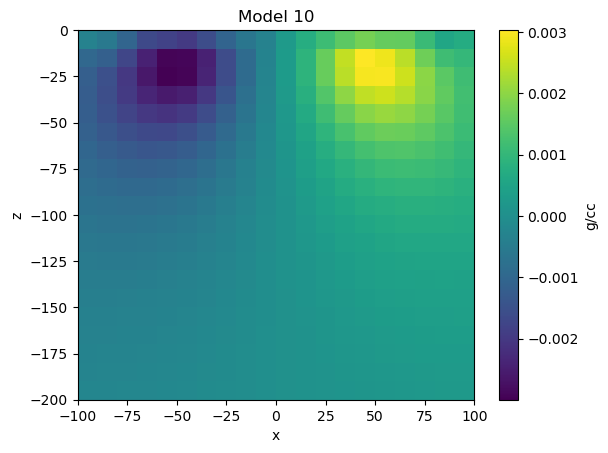

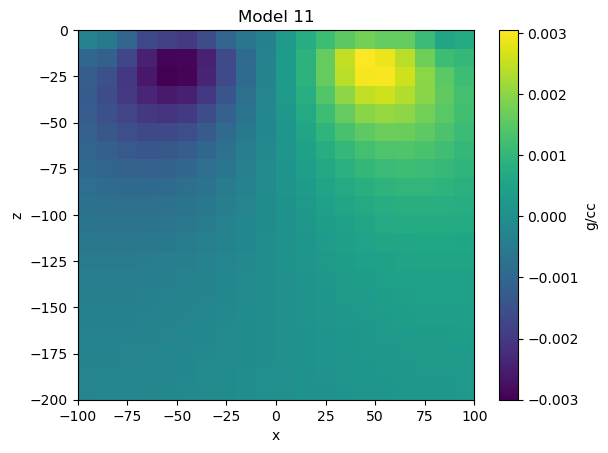

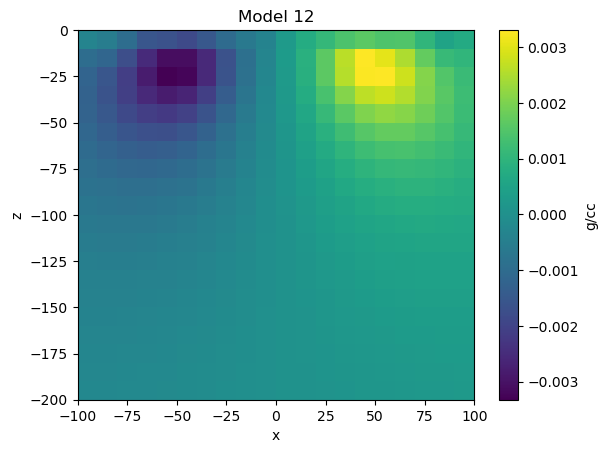

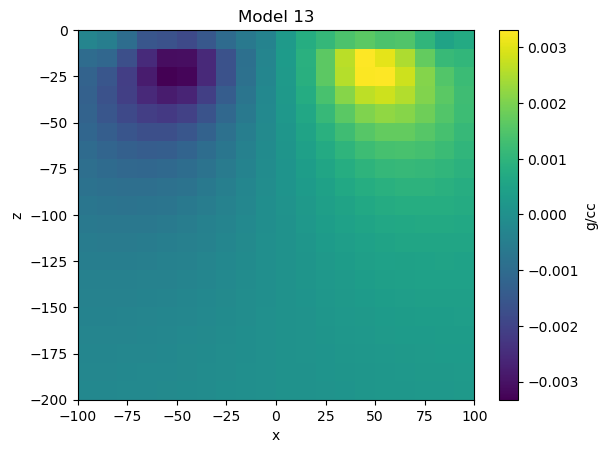

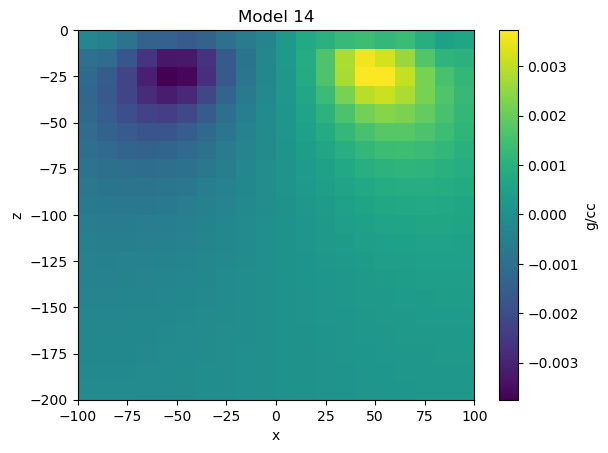

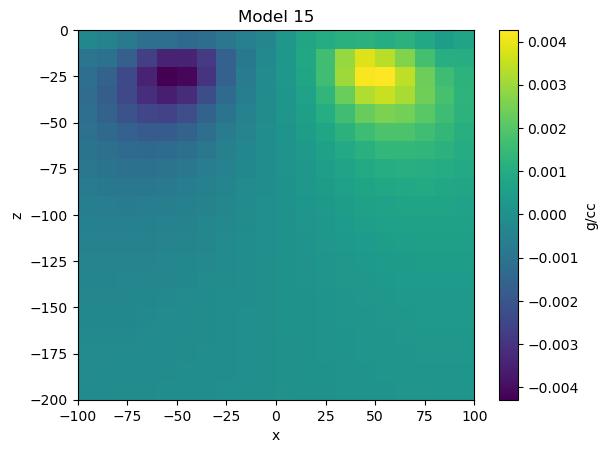

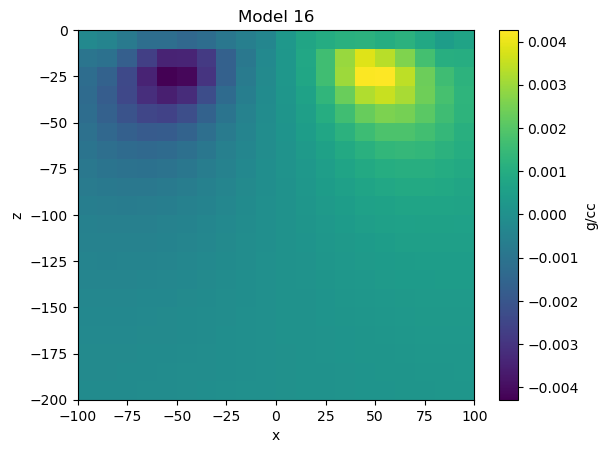

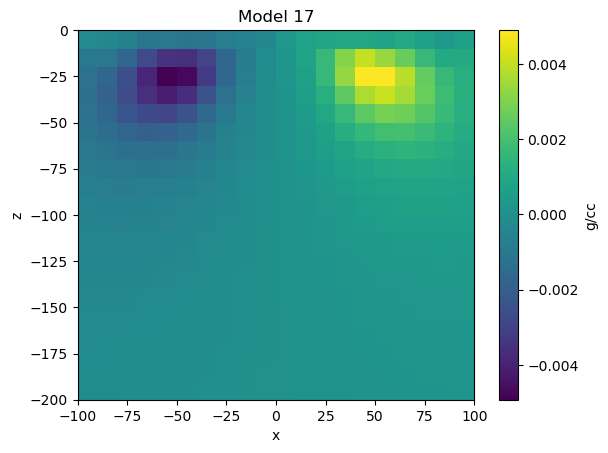

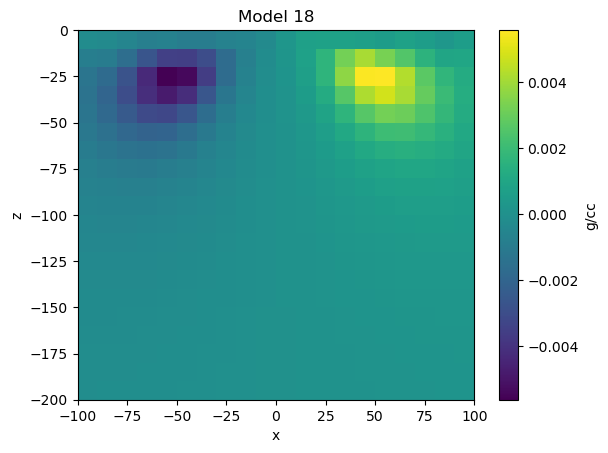

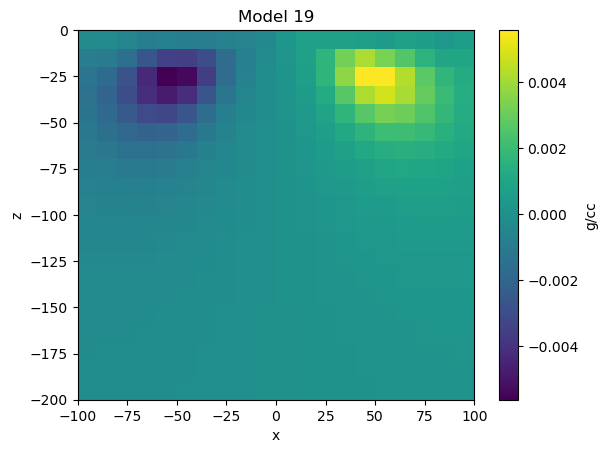

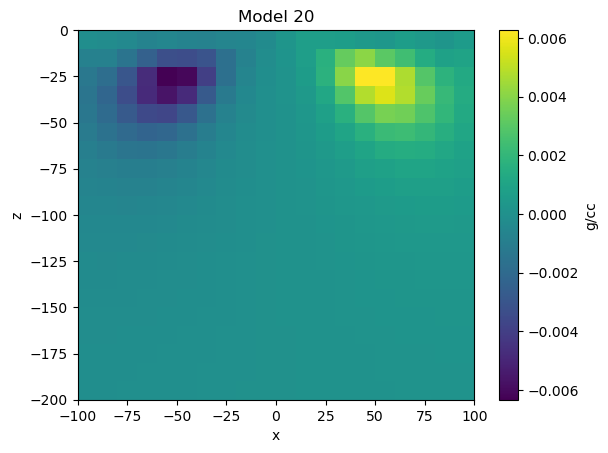

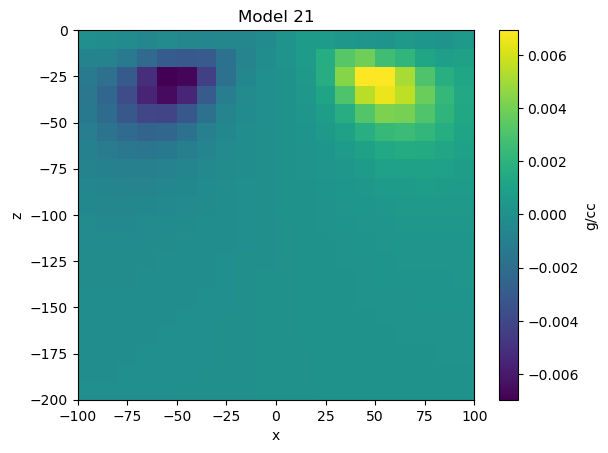

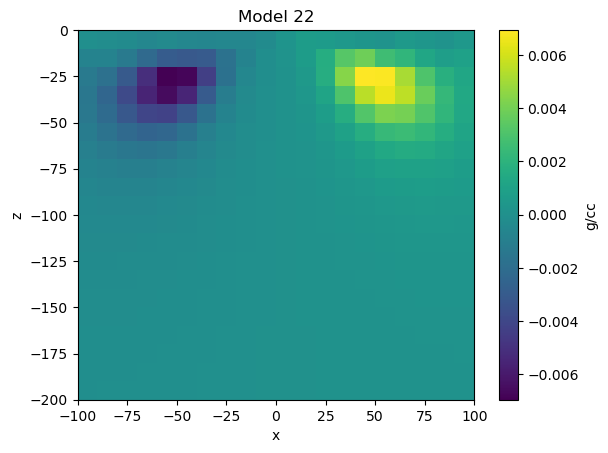

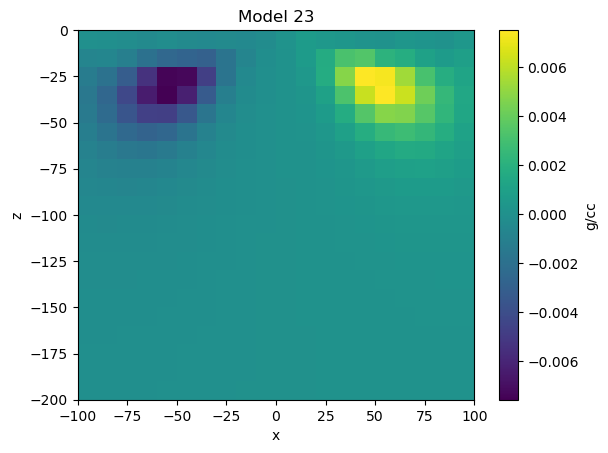

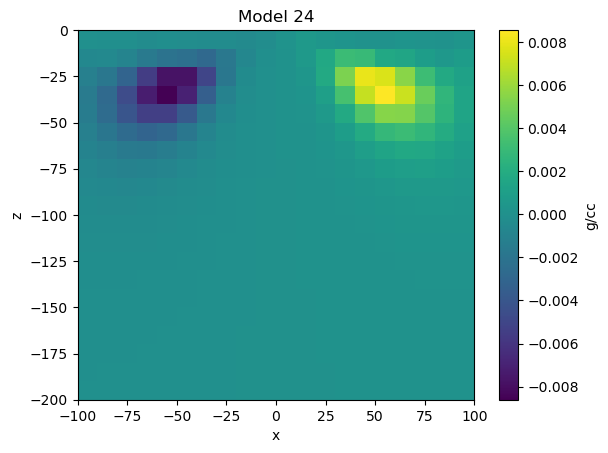

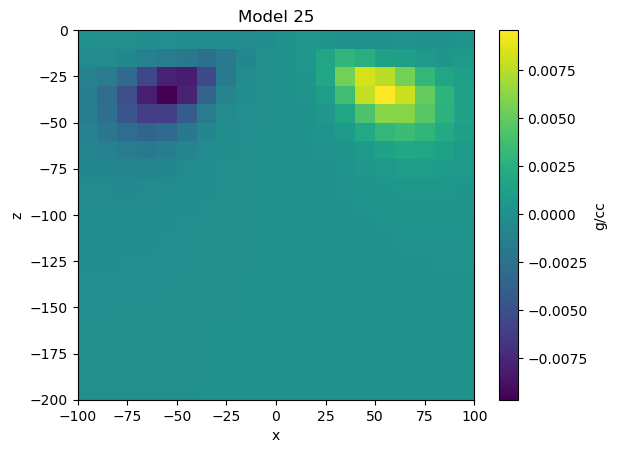

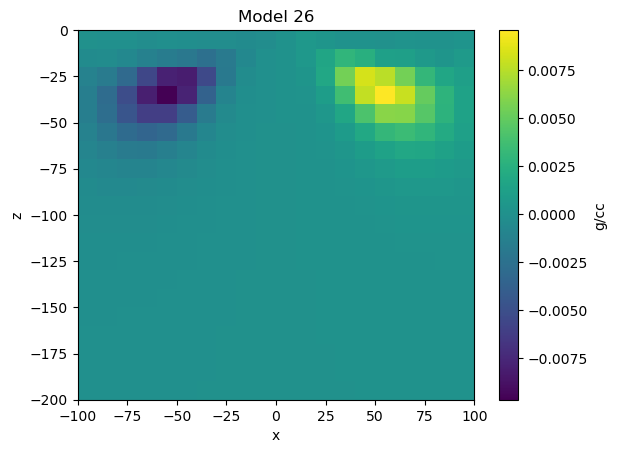

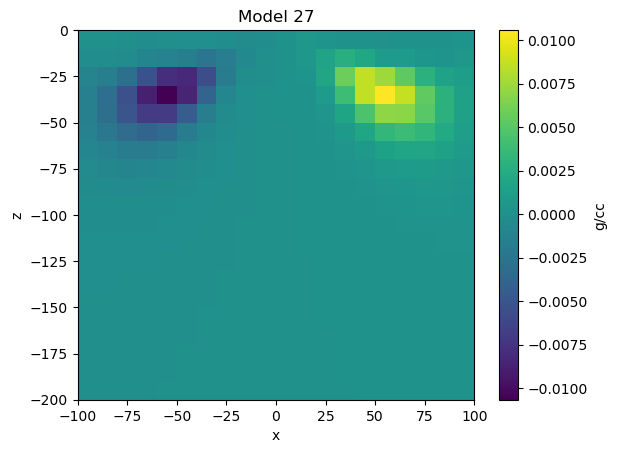

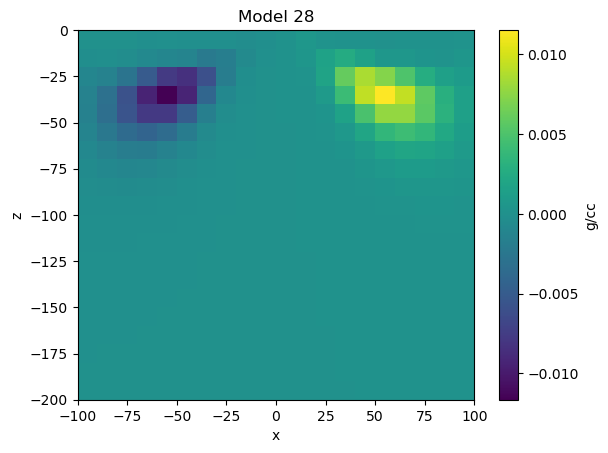

In [29]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()